<a href="https://colab.research.google.com/github/malborroni/RECMojion/blob/master/parallel3fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Fold Generator

Script per la generazione del dataset per cross validation con data augmentation  

## Import Librerie

In [0]:
import keras
from keras.datasets import mnist 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils # per convertire le y
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from keras import regularizers
from keras.layers.core import Dropout

Using TensorFlow backend.


In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, 
    IAAPiecewiseAffine, IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, ElasticTransform
)
import os
import cv2 as cv
from tqdm import tqdm_notebook
import random
from albumentations import RGBShift

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import Dataset 
Immagini X e labels y

In [0]:
import pickle
with open('/content/drive/My Drive/XY.pkl', 'rb') as infile:
    result = pickle.load(infile)
X,Y=result

Per prima cosa creo la divisione

In [0]:
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)
# define 3-fold cross validation 
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

In [0]:
kf =kfold.split(X, Y)

In [0]:
kf_split=list(kf) 
# lista degli indici dei valori di train e test per i 3 fold

In [0]:
# indici per ogni divisione
train1,test1 =kf_split[0] 
train2,test2 =kf_split[1]
train3,test3 =kf_split[2]

Creazione di 9 dataset dal dataset principale, in particolare un train un test ed un validation set per ognuno dei 3 fold

In [0]:
    x_train1 = X[train1]
    x_test1 = X[test1]
    y_train1 = Y[train1]
    y_test1 = Y[test1]

In [0]:
    x_train2 = X[train2]
    x_test2 = X[test2]
    y_train2 = Y[train2]
    y_test2 = Y[test2]

In [0]:
    x_train3 = X[train3
    x_test3 = X[test3]
    y_train3 = Y[train3]
    y_test3 = Y[test3]

In [0]:
from sklearn.model_selection import train_test_split
def val_split(x_train, y_train):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .25, random_state = 42, stratify = y_train)
    return x_train, x_val, y_train, y_val

In [0]:
x_train1, x_val1, y_train1, y_val1 = val_split(x_train1, y_train1)
x_train2, x_val2, y_train2, y_val2 = val_split(x_train2, y_train2)
x_train3, x_val3, y_train3, y_val3 = val_split(x_train3, y_train3)

Check per verificare che sia andato tutto bene in termini di dimensioni e coorrispondenze tra immagini e labels

In [0]:
print(x_train1.shape,x_val1.shape,x_test1.shape)
print(x_train2.shape,x_val2.shape,x_test2.shape)
print(x_train3.shape,x_val3.shape,x_test3.shape)

(1294, 224, 224, 3) (432, 224, 224, 3) (864, 224, 224, 3)
(1295, 224, 224, 3) (432, 224, 224, 3) (863, 224, 224, 3)
(1295, 224, 224, 3) (432, 224, 224, 3) (863, 224, 224, 3)


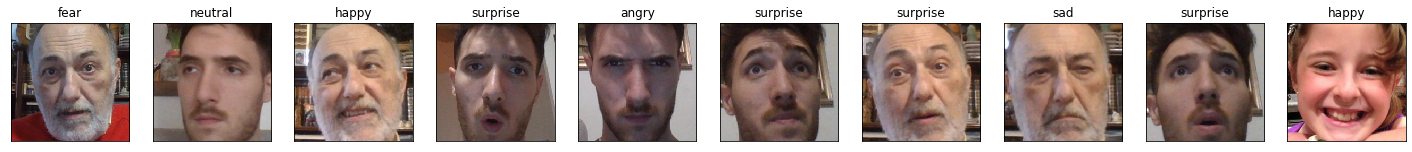

In [0]:
import random
import cv2 as cv
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(y_train1))
    plt.imshow(cv.cvtColor(x_train1[l], cv.COLOR_BGR2RGB))
    plt.title(str(y_train1[l]))

## Data Augmentation

In [0]:
def augment(aug, image):
    return aug(image=image)['image']

In [0]:
augment_flow = Compose([Rotate(p = 0.5, limit = (60)),
                       RGBShift(p = 0.5),
                       RandomBrightnessContrast(p=0.5, brightness_limit = 0.7, contrast_limit = 0.7),
                       OneOf([Blur(blur_limit = 10, p = 1),
                              MotionBlur(blur_limit = 20, p = 1),
                              GaussNoise(var_limit = (50,200), p = 1)], p = 0.5)
                        ], p = 1)


In [0]:
multiplier = 3 # significa 4x come augmentation (verifica siano 6600 in train alla fine)
def data_aug(x_train,y_train):
    '''
    Funzione per la data augmentation, prende in input immagini e labels, applica l'augment flow e restituisce
    la lista delle immagini create. 
    '''
    res_x = []
    res_y = []
    for i in tqdm_notebook(range(len(x_train))):
        for n in range(multiplier):
            res_x.append(augment(augment_flow, x_train[i]))
            res_y.append(y_train[i])
    return res_x,res_y

Augmentation e trasformazione in array di numpy per ognuno dei 3 fold

In [0]:
res_x,res_y=data_aug(x_train1,y_train1) # augmentation
print("Immagini elaborate")
x_train1=np.append(np.array(res_x),x_train1,axis=0)
y_train1=np.append(np.array(res_y),y_train1,axis=0)


Immagini elaborate
X appese
Y appese
Salvataggio...


In [0]:
res_x,res_y=data_aug(x_train2,y_train2) #augmentation
print("Immagini elaborate")
x_train2=np.append(np.array(res_x),x_train2,axis=0)
y_train2=np.append(np.array(res_y),y_train2,axis=0)


Immagini elaborate
X appese
Y appese
Salvataggio...


In [0]:
res_x,res_y=data_aug(x_train3,y_train3) # augmentation
print("Immagini elaborate")
x_train3=np.append(np.array(res_x),x_train3,axis=0)
y_train3=np.append(np.array(res_y),y_train3,axis=0)


Immagini elaborate
X appese
Y appese
Salvataggio...


# Feature Extraction

Fase finale in cui vengono fatte passare tutte le immagini dei 3 fold per la VggFace per la feature extraction

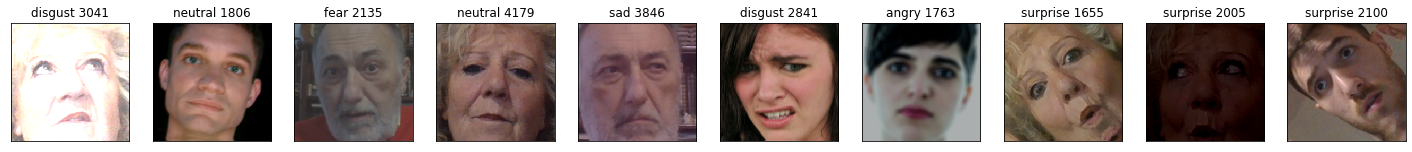

In [0]:
# check immagini aumentate e non
import random
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(y_train2))
    plt.imshow(x_train2[l][:,:,::-1])
    plt.title(str(y_train2[l])+' '+str(l))

In [0]:
! sudo pip install git+https://github.com/rcmalli/keras-vggface.git
# import repository con vggface

In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
# Import dei pesi della rete 
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50') 

In [0]:
from keras import Model
# Creazione del modello con output al layer scelto nel progetto come migliore
model = Model(inputs=base_model.input, outputs=base_model.get_layer("activation_51").output)

Fold 1

In [0]:
x_train1 = model.predict(preprocess_input(x_train1.astype('float64'),version=2)).astype('float32')
x_test1 = model.predict(preprocess_input(x_test1.astype('float64'),version=2)).astype('float32')
x_val1 =  model.predict(preprocess_input(x_val1.astype('float64'),version=2)).astype('float32')

In [0]:
np.savez_compressed('/content/drive/My Drive/AML/extracted_3fold1.npz',
                    x_train1 = x_train1, y_train1 = y_train1,
                    x_val1 = x_val1, y_val1 = y_val1,
                    x_test1 = x_test1, y_test1 = y_test1)

Fold2

In [0]:
x_train2 = model.predict(preprocess_input(x_train2.astype('float64'),version=2)).astype('float32')
x_test2 = model.predict(preprocess_input(x_test2.astype('float64'),version=2)).astype('float32')
x_val2 =  model.predict(preprocess_input(x_val2.astype('float64'),version=2)).astype('float32')

In [0]:
np.savez_compressed('/content/drive/My Drive/AML/extracted_3fold2.npz',
                    x_train2 = x_train2, y_train2 = y_train2,
                    x_val2 = x_val2, y_val2 = y_val2,
                    x_test2 = x_test2, y_test2 = y_test2)

Fold3

In [0]:
x_train3 = model.predict(preprocess_input(x_train3.astype('float64'),version=2)).astype('float32')
x_test3 = model.predict(preprocess_input(x_test3.astype('float64'),version=2)).astype('float32')
x_val3 =  model.predict(preprocess_input(x_val3.astype('float64'),version=2)).astype('float32')

In [0]:
np.savez_compressed('/content/drive/My Drive/AML/extracted_3fold3.npz',
                    x_train3 = x_train3, y_train3 = y_train3,
                    x_val3 = x_val3, y_val3 = y_val3,
                    x_test3 = x_test3, y_test3 = y_test3)